# Quandela Cloud account

Steps:
 
   1. Go to __[QUANDELA Cloud$_{\beta}$](https://cloud.quandela.com/webide/register)__  and create an account.
   
   2. Once you have an account, log in into __[QUANDELA Cloud$_{\beta}$](https://cloud.quandela.com/webide/login)__.
   
   3. Go to _Tokens_ (expected to be on the top left corner menu) and click _Create New_. You need to choose the token name (e.g., _first_token_) and duration (e.g., 3 days).

Set your token ID to a variable. 

In [2]:
token_qcloud = '123ABC'

In order to get a cleaner output, the packages' warnings were disabled.

In [1]:
import warnings
warnings.filterwarnings("ignore")

# Unitary matrices and Optical Circuits

Define the matrix representation of the Hadamard gate, $H$, which puts one qubit into a equal superposition.

In [3]:
import perceval as pcvl

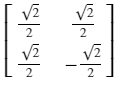

In [4]:
a = (1/2)**(1/2)
h = a * pcvl.Matrix([[1,  1],
                     [1, -1]])
pcvl.pdisplay(h)

Alternative way to define it.

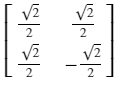

In [5]:
m = f"{a} {a} \n {a} {-a}"
h = pcvl.Matrix(m)
pcvl.pdisplay(h)

Check if $H$ is a unitary gate.

In [6]:
h.is_unitary()

True

Create and display a circuit indicating the operation by a box. Note that this gate acts on one qubit, which is mapped to two spatial modes.

In [7]:
h_circuit = pcvl.Unitary(U=h, name='H')

In [8]:
from perceval.rendering.circuit import SymbSkin

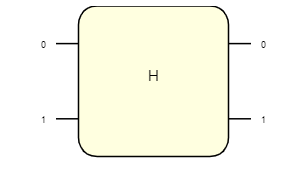

In [9]:
pcvl.pdisplay(h_circuit, skin=SymbSkin())

Alternative display.

In [10]:
from perceval.rendering.circuit import SymbSkin, PhysSkin

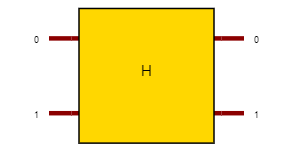

In [11]:
pcvl.pdisplay(h_circuit, skin=PhysSkin())

Now we need to decompose the circuit into an optical circuit.

In [12]:
from perceval import BS, PS

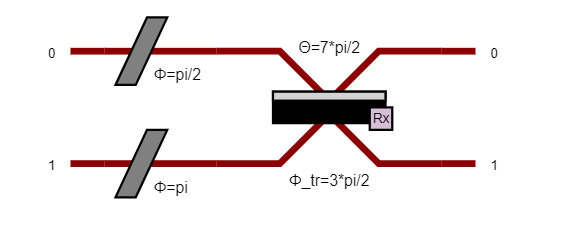

In [13]:
h_opti_circuit = pcvl.Circuit.decomposition(
    h,
    BS(theta=pcvl.P('theta'), phi_tr=pcvl.P('psi')),
    phase_shifter_fn=PS)

pcvl.pdisplay(h_opti_circuit, skin=PhysSkin(), render_size=1.5)

We can sample the circuit implementing the superposition as follows. 
Set an input Fock state, e.g, $|0,1 \rangle$, which maps qubit $|1\rangle$. 

In [14]:
input_state = pcvl.BasicState([0, 1])
print(input_state)

|0,1>


or

In [15]:
input_state = pcvl.BasicState("|0,1>")
print(input_state)

|0,1>


Instantiate a backend, e.g., "Naive", 

In [16]:
p = pcvl.Processor("Naive", h_opti_circuit)
p.with_input(input_state)

Sample the circuit $n$ times.

In [17]:
n = 10
sampler = pcvl.algorithm.Sampler(p)
samples = sampler.samples(n)

In [18]:
samples['results']

[|1,0>, |0,1>, |0,1>, |1,0>, |0,1>, |0,1>, |0,1>, |1,0>, |0,1>, |0,1>]

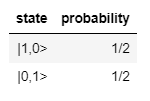

In [19]:
distribution = sampler.probs()["results"]
pcvl.pdisplay(distribution)

Measuring the state $|0,1\rangle$ or $|1,0\rangle$ has the same probability, as theoretically expected. 

Alternatively, we can create the beam splitter circuit for $H \left( \frac{\pi}{2} \right)=H$ gate and then calculate the corresponding unitary matrix.

In [20]:
import perceval as pcvl
import perceval.components.unitary_components as comp

In [21]:
superpositon = comp.BS.H()

Matrix and input parameters of the beam splitter matrix convention for $H(\theta)$ gate.

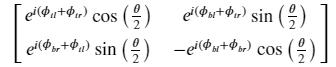

In [22]:
pcvl.pdisplay(superpositon.definition())

Default parameters.

In [23]:
superpositon.get_parameters(all_params=True)

[Parameter(name='theta', value=pi/2, min_v=0.0, max_v=12.566370614359172),
 Parameter(name='phi_tl', value=0, min_v=0.0, max_v=6.283185307179586),
 Parameter(name='phi_bl', value=0, min_v=0.0, max_v=6.283185307179586),
 Parameter(name='phi_tr', value=0, min_v=0.0, max_v=6.283185307179586),
 Parameter(name='phi_br', value=0, min_v=0.0, max_v=6.283185307179586)]

Display the circuit and matrix with default parameters, i.e., $H \left( \frac{\pi}{2} \right)$

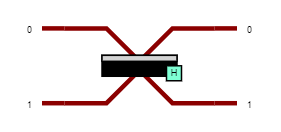

In [24]:
pcvl.pdisplay(superpositon)

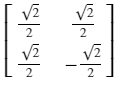

In [25]:
pcvl.pdisplay(superpositon.compute_unitary())

Which is the expected matrix of $H$. Now we will implement an optical circuit that perform first the operation $H$, then the $Z$ gate, and last the $H$ gate again.

Create a circuit with 2 spatial modes (for one qubit representation).

In [26]:
x_circuit = pcvl.Circuit(2)

Create the $Z$ gate circuit from the unitary matrix representation.

In [27]:
z = pcvl.Matrix([[1,  0],
                 [0, -1]])

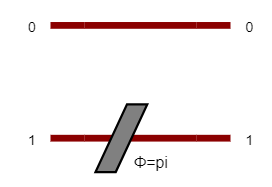

In [28]:
z_opti_circuit = pcvl.Circuit.decomposition(
    z,
    BS(theta=pcvl.P('theta'), phi_tr=pcvl.P('psi')),
    phase_shifter_fn=PS)

pcvl.pdisplay(z_opti_circuit, skin=PhysSkin(), render_size=1.5)

Add the three operations and visualize the final circuit.

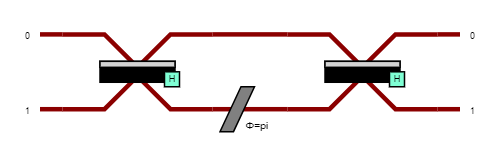

In [29]:
x_circuit.add(0, comp.BS.H())
x_circuit.add(0, z_opti_circuit, merge=True)
x_circuit.add(0, comp.BS.H())
pcvl.pdisplay(x_circuit, skin=PhysSkin())

Let us calculate the probability of the output states for the two possible qubits input: $|0 \rangle \rightarrow |1,0 \rangle$ and  $|1 \rangle \rightarrow |0,1 \rangle$. 

In [30]:
input_state_0 = pcvl.BasicState("|0,1>")
input_state_1 = pcvl.BasicState("|1,0>")

In [31]:
naive_p = pcvl.Processor("Naive", x_circuit)

In [32]:
results_prob = pcvl.algorithm.Analyzer(naive_p, [input_state_0, 
                                                 input_state_1], "*")

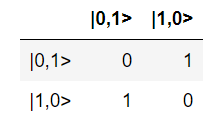

In [33]:
pcvl.pdisplay(results_prob)

As can be seen in the above table, if we input $|0 \rangle$ we get $|1 \rangle$ and if we input $|1 \rangle$ we get $|0 \rangle$, both with theoretical probability $1$, which is the behaviour of a bit flip operation, i.e., the $X$ ($NOT$) gate.  This is due to the following equality 

$$\begin{equation*}
	HZH = \frac{1}{\sqrt{2}}\begin{pmatrix}
			1 & 1\\
			1 & -1
	\end{pmatrix} \begin{pmatrix}
			1 & 0\\
			0 & -1
	\end{pmatrix} \frac{1}{\sqrt{2}} \begin{pmatrix}
			1 & 1\\
			1 & -1
	\end{pmatrix} = \begin{pmatrix}
			0 & 1\\
			1 & 0
	\end{pmatrix} = X \,,
\end{equation*}$$

which always flips the computational basis state.

## Run on a quantum simulator

Execute the superposition circuit on backend _sim:ascella_, which simulates Quandela's qpu called _ascella_.

In [34]:
remote_simulator = pcvl.RemoteProcessor("sim:ascella", token_qcloud)

In [35]:
specs = remote_simulator.specs
specs["constraints"]

{'max_mode_count': 12,
 'max_photon_count': 6,
 'min_mode_count': 1,
 'min_photon_count': 1}

Using this simulator the maximum number of qubits is $6$, mapped into $6$ photons and $12$ spatial modes.

In [36]:
input_state = pcvl.BasicState("|1,0>")

In [37]:
remote_simulator.set_circuit(superpositon)
remote_simulator.with_input(input_state)

In [38]:
from perceval.algorithm import Sampler

In [39]:
sampler = Sampler(remote_simulator)
sampler.default_job_name = "h_gate_superposition"  

Run $n$ times.

In [40]:
n = 1000
remote_job = sampler.sample_count.execute_async(n)

Note that _.execute_async()_ allows to keep running function on this notebook while awaiting for the results. You can verify its status on __[QUANDELA Cloud$_{\beta}$](https://cloud.quandela.com/webide/register)__ $\rightarrow$ _Jobs_$\rightarrow$ status. Alternative, it is possible to monitor the job status with the following code available in Perceval documentation __[Remote computing with Perceval](https://perceval.quandela.net/docs/notebooks/Remote%20computing.html)__. However, by running it you can not keep running function on this notebook until the job is done.

In [41]:
import time
from tqdm.notebook import tqdm

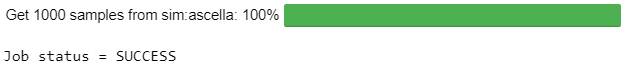

In [42]:
previous_prog = 0

with tqdm(total=1, bar_format='{desc}{percentage:3.0f}%|{bar}|') as tq:

    tq.set_description(f'Get {n} samples from {remote_simulator.name}')
    
    while not remote_job.is_complete:
    
        tq.update(remote_job.status.progress/100-previous_prog)
        previous_prog = remote_job.status.progress/100
        time.sleep(1)
    
    tq.update(1-previous_prog)
    tq.close()

print(f"Job status = {remote_job.status()}")

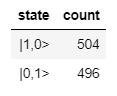

In [43]:
output_distribution = remote_job.get_results()['results']
pcvl.pdisplay(output_distribution)

The simulated results are numerically close to the expected theoretical equal probability of $0.5$.

## Run on a real quantum processor

Now run the $X$ identity circuit on _ascella_, a real photonic quantum chip.

In [44]:
remote_qpu = pcvl.RemoteProcessor("qpu:ascella", token_qcloud)

In [45]:
input_state =  pcvl.BasicState([1, 0])
remote_qpu.set_circuit(x_circuit)
remote_qpu.with_input(input_state)

sampler_on_qpu = Sampler(remote_qpu)
remote_job = sampler_on_qpu.probs
remote_job.name = "qpu_x_gate"

remote_job.execute_async()

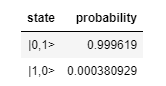

In [46]:
results = remote_job.get_results()
output_distribution = results["results"]
pcvl.pdisplay(output_distribution)

$99.96\%$ of the times the circuit was measured at state $|0,1 \rangle$, i.e., it flipped the input $|0 \rangle$ into $|1 \rangle$, as theoretically expected. It was also measured at state  $|1,0 \rangle\,,$ however, the percentage is so small that, in this case, we can neglect it. For more complex circuits the errors might be significant and some efficient error-correction technique or hardware enhancement might circumvent the problem. 

It is also possible to fetch past jobs using the job id available on  __[QUANDELA Cloud$_{\beta}$](https://cloud.quandela.com/webide/login)__ $\rightarrow$ _Jobs_ section (expected to be the third option on the left menu). 

In [47]:
remote_processor = pcvl.RemoteProcessor("sim:ascella", token_qcloud)
job_id = "abc123"
async_job = remote_processor.resume_job(job_id)

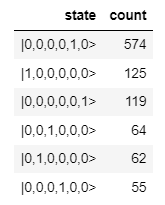

In [48]:
pcvl.pdisplay(async_job.get_results()['results'])

# Optical Circuit from Gate Circuit

It is possible to convert gate model circuits created using _Qiskit_ (developed by IBM to interact with their superconducting quantum computer) into Perceval linear optical circuits. Here, we briefly explain the controlled-$NOT$ ($CNOT$) gate, which creates a quantum correlation between two qubits stronger than classical correlation (known as _entanglement_), by leveraging the identity $X=HZH$.

In [49]:
import qiskit

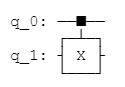

In [50]:
cnot_circuit = qiskit.QuantumCircuit(2)
cnot_circuit.cnot(0, 1)
cnot_circuit.draw(initial_state=False)

The above displayed circuit shows the $CNOT$ gate circuit, where qubit $q_0$ acts as a controller of the $X(NOT)$ gate being applied or not to qubit $q_1$. If $q_0$ is set to  $|1 \rangle\ $, then it triggers the $X$ gate and $q_1$ is flipped. If is set to  $|0 \rangle\ $ does not trigger the $X$ gate. We have seen that $HZH=X$, let us define the new circuit. Note that increasing the number of gates potentially leads to higher error rates but here we want to highlight alternative implementations.

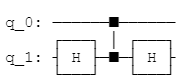

In [51]:
cz_circuit = qiskit.QuantumCircuit(2)
cz_circuit.h(1)
cz_circuit.cz(0, 1)
cz_circuit.h(1)
cz_circuit.draw(initial_state=False)

Now convert to a Perceval circuit.

In [52]:
from perceval.converters import QiskitConverter
from perceval.components import catalog

In [53]:
qiskit_converter = QiskitConverter(catalog, backend_name="Naive")
cz_opti_circuit = qiskit_converter.convert(cz_circuit,
                                          use_postselection=True)

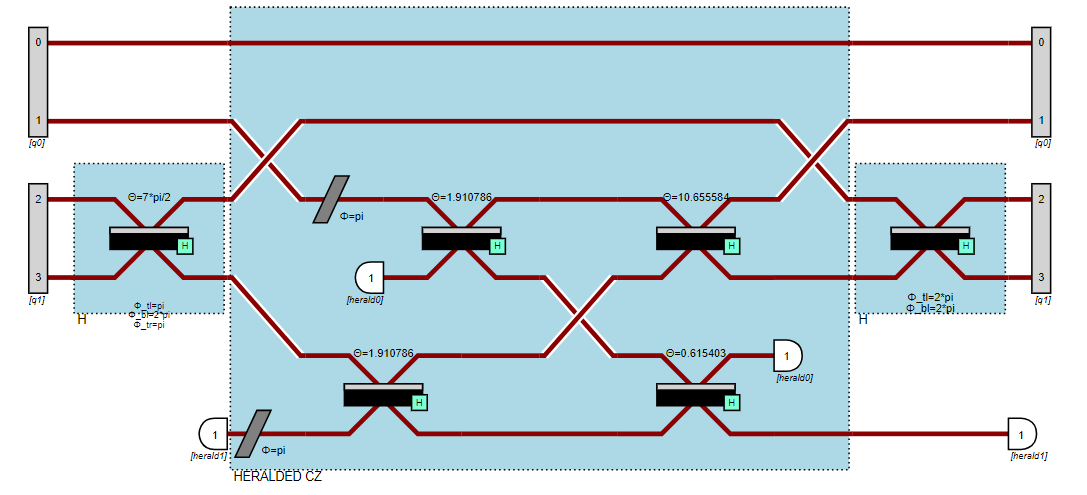

In [54]:
pcvl.pdisplay(cz_opti_circuit, recursive=True, render_size=0.8)

More details are available on Perceval documentation __[Decomposing Qiskit circuits](https://perceval.quandela.net/docs/notebooks/Qiskit%20conversion.html)__